# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*


In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
# Import libraries
import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt                        
from tqdm import tqdm
import torch
import torchvision.models as models
import os
import pandas as pd                    
import random
import matplotlib as mpl
import seaborn as sns
from PIL import Image
from PIL import ImageFile
import torchvision.transforms as transforms
from torchvision import datasets
from matplotlib.pyplot import imshow
from IPython.display import display
import torch.optim as optim
%matplotlib inline

In [3]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


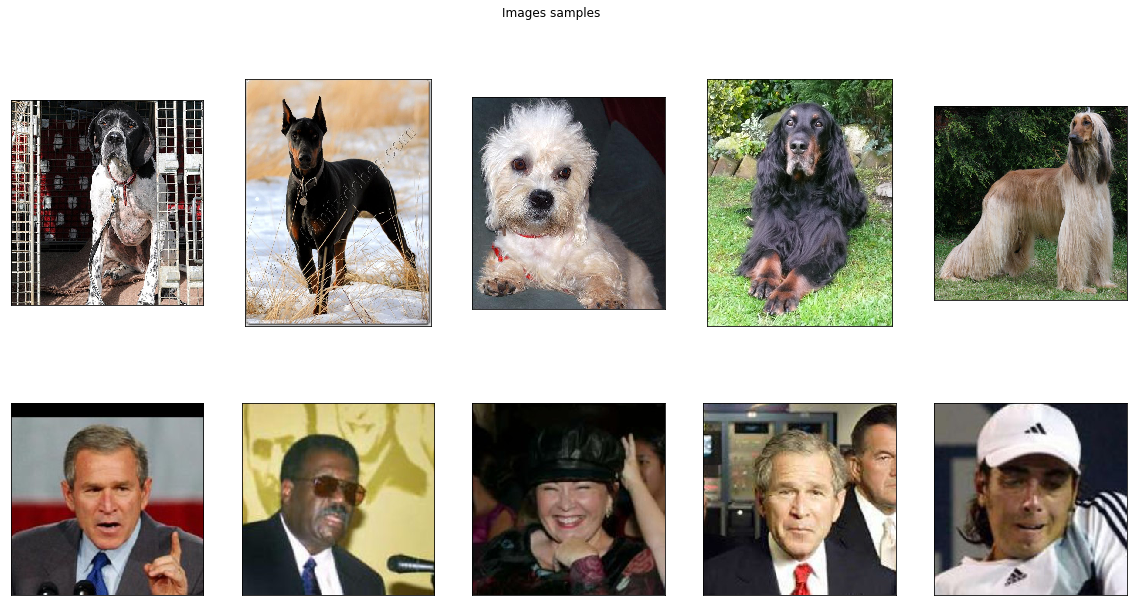

In [4]:
## Display random samples on the dataset

# Create a figure object
fig = plt.figure(figsize=(20,10))
fig.suptitle('Images samples')

# Iterate 5 times over the dataset and show random images
for i in range(5):
    
    random_index = random.randint(0, len(dog_files)-1)
   
    dog_sample = cv2.imread(dog_files[random_index])
    ax = fig.add_subplot(2,5, i + 1, xticks=[], yticks=[])
    ax.imshow(cv2.cvtColor(dog_sample, cv2.COLOR_BGR2RGB))  
    
    human_sample = cv2.imread(human_files[random_index])
    ax2 = fig.add_subplot(2,5, i + 6 , xticks=[], yticks=[])
    ax2.imshow(cv2.cvtColor(human_sample, cv2.COLOR_BGR2RGB))

In [5]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_total_files = np.array(glob("/data/dog_images/*/*/*"))
dog_train = np.array(glob("/data/dog_images/train/*/*"))
dog_valid = np.array(glob("/data/dog_images/valid/*/*"))
dog_test = np.array(glob("/data/dog_images/test/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images,' % len(dog_total_files))
print(f'{len(dog_train)} for training, {len(dog_valid)} for validation and {len(dog_test)} for testing.')

There are 13233 total human images.
There are 8351 total dog images,
6680 for training, 835 for validation and 836 for testing.


In [6]:
# load dataset paths
dog_train_path = '/data/dog_images/train'
dog_valid_path = '/data/dog_images/valid'
dog_test_path = '/data/dog_images/test'
humans_path = '/data/lfw'


def calculate_images(folder):
    '''
    Calculate information about the number of files in a folder. 
    
    Args:
        folder: path to a folder
        
    Returns:
        total breed folders, mean files in a breed folder, maximum files in a breed folder, 
        minimum files in a breed folder
    '''
    total_images = []
    
    # Iterate over the folder and append the number of each folder to total_images
    for breed in os.listdir(folder):
        breed_folder = os.path.join(folder, breed)
        if os.path.isdir(breed_folder):
            breed_images = [dog for dog in os.listdir(breed_folder) if os.path.isfile(os.path.join(breed_folder, dog))]
            total_images.append(len(breed_images))
    
    # Transform to numpy array and return the calculations
    np_total_images = np.array(total_images)

    return len(total_images), int(np_total_images.mean()), np_total_images.max(), np_total_images.min()


# Calculate the total breeds and the mean, maximum and minimum images of each.
# Calculate the same values for different persons
train_breeds, train_mean, train_max, train_min = calculate_images(dog_train_path)
valid_breeds, valid_mean, valid_max, valid_min = calculate_images(dog_valid_path)
test_breeds, test_mean, test_max, test_min = calculate_images(dog_test_path)
different_humans, human_mean, human_max, human_min = calculate_images(humans_path)

# Print the results
print(f'Total breeds in train {train_breeds}. Mean images for each {train_mean}, maximum {train_max}, minimum {train_min}')
print(f'Total breeds in validation {valid_breeds}. Mean images for each {valid_mean}, maximum {valid_max}, minimum {valid_min}')
print(f'Total breeds in test {test_breeds}. Mean images for each {test_mean}, maximum {test_max}, minimum {test_min}')
print(f'Total different humans {different_humans}. Mean images for each {human_mean}, maximum {human_max}, minimum {human_min}')

Total breeds in train 133. Mean images for each 50, maximum 77, minimum 26
Total breeds in validation 133. Mean images for each 6, maximum 9, minimum 4
Total breeds in test 133. Mean images for each 6, maximum 10, minimum 3
Total different humans 5749. Mean images for each 2, maximum 530, minimum 1


In [7]:
def list_breeds(folder):
    '''
    Extract all the names of dog breed folders in a folder 
    
    Args:
        folder: path to a folder
        
    Returns:
        numpy array of dog breed names 
    '''
    return np.array([breed.split('.')[1] for breed in os.listdir(folder) if os.path.isdir(os.path.join(folder, breed))])


def compare_breeds(folder_a, folder_b):
    '''
    Checks if two given arrays have the same breed names
    
    Args:
        folder_a: path to a folder
        folder_b: path to a folder to compare to
        
    Returns:
        boolean with the result 
    '''
    return (folder_a==folder_b).all()
    
# Check if train, validation and test has the same breeds   
print(f'Training and validation sets has the same breeds: {compare_breeds(list_breeds(dog_train_path), list_breeds(dog_valid_path))}')       
print(f'Training and test sets has the same breeds: {compare_breeds(list_breeds(dog_train_path), list_breeds(dog_test_path))}')          

Training and validation sets has the same breeds: True
Training and test sets has the same breeds: True


In [8]:
def calculate_breed_images(folder):
    '''
    Calculate the total number of each breed images in a folder
    
    Args:
        folder: path to a folder
        
    Returns:
        int:  
    '''
    total_images = []
    for breed in os.listdir(folder):
        breed_folder = os.path.join(folder, breed)
        if os.path.isdir(breed_folder):
            breed_images = [dog for dog in os.listdir(breed_folder) if os.path.isfile(os.path.join(breed_folder, dog))]
            total_images.append(len(breed_images))
            
    return total_images


# Load the total number of images in a pandas dataframe
data = np.array([calculate_breed_images(dog_train_path), calculate_breed_images(dog_valid_path), calculate_breed_images(dog_test_path)])
columns_index = list_breeds(dog_train_path)
dogs_df = pd.DataFrame(data=data, columns=columns_index, index=['train', 'valid', 'test'])
dogs_df.head(5)

Mastiff  Doberman_pinscher  Curly-coated_retriever  Borzoi  \
train       58                 47                      50      56   
valid        7                  6                       6       7   
test         7                  6                       7       7   

       Bichon_frise  Chinese_crested  Finnish_spitz  Welsh_springer_spaniel  \
train            62               50             34                      44   
valid             7                7              4                       6   
test              8                6              4                       5   

       Bedlington_terrier  Papillon   ...     Gordon_setter  \
train                  48        63   ...                43   
valid                   6         8   ...                 6   
test                    6         8   ...                 5   

       German_wirehaired_pointer  Irish_water_spaniel  Norwich_terrier  \
train                         42                   51               44   
valid                          5                    7                6   
test                           5                    6                5   

       Norwegian_elkhound  Affenpinscher  Basset_hound  Maltese  Keeshond  \
train                  45             64            73       48        44   
valid                   6              8             9        6         6   
test                    5              8            10        6         5   

       Lowchen  
train       34  
valid        4  
test         4  

[3 rows x 133 columns]

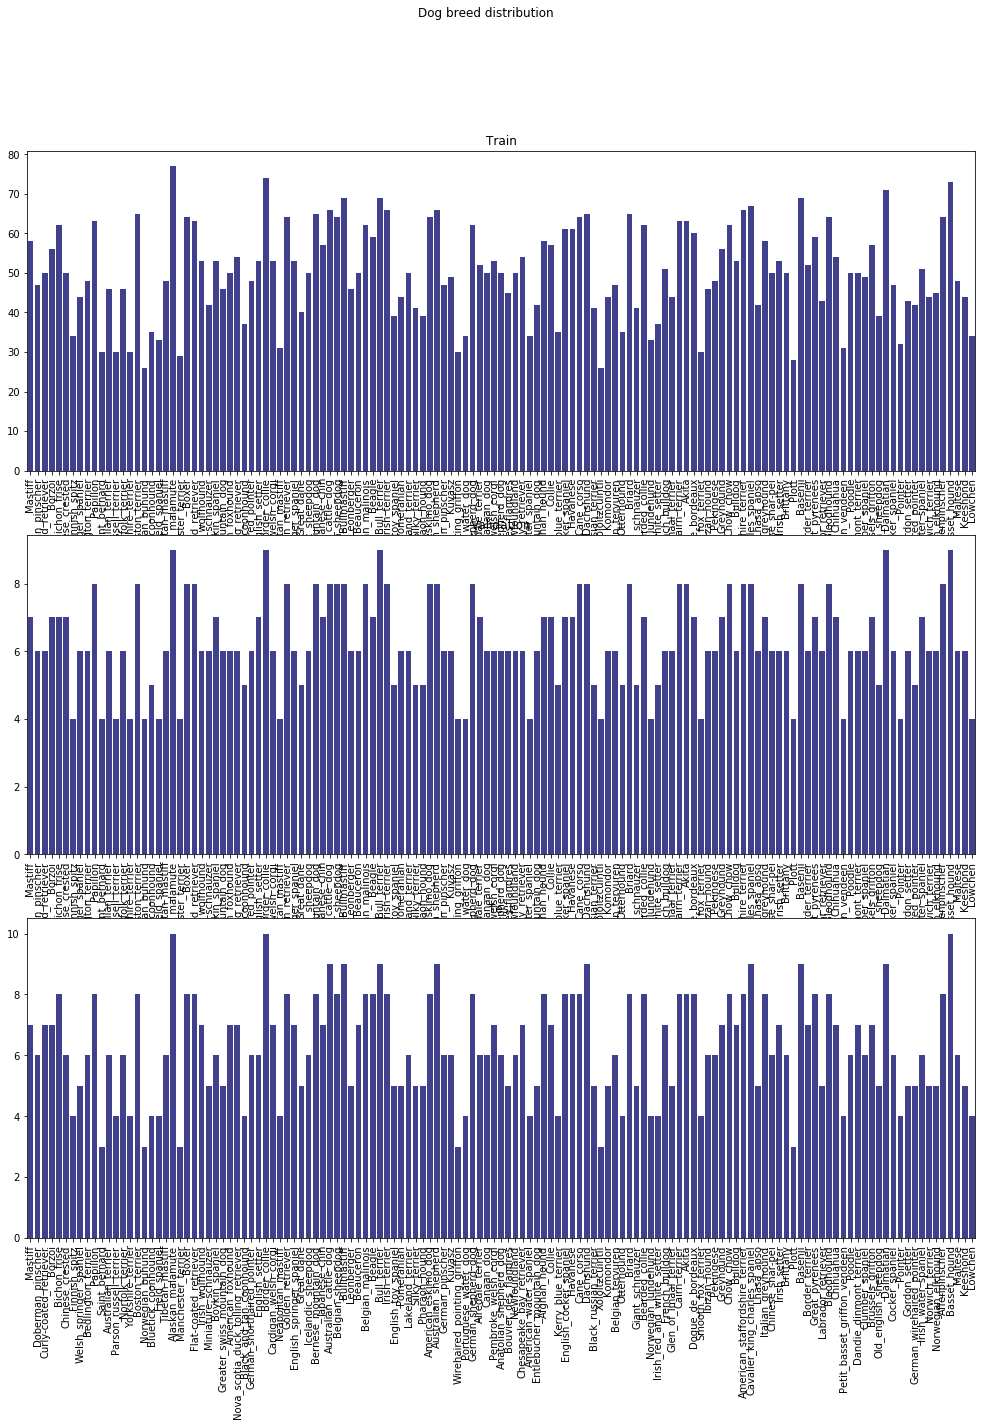

In [9]:
# Create a figure object
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(17,20))
fig.suptitle('Dog breed distribution')

# Visualize the distribution of the dataset with the previous dataset
sns.barplot( x = dogs_df.columns, y = dogs_df.values[0], alpha=0.8, ax=ax1, color="navy")
labels = ax1.get_xticklabels();
ax1.set_xticklabels(labels, rotation=90);
ax1.set_title("Train");

sns.barplot( x = dogs_df.columns, y = dogs_df.values[1], alpha=0.8, ax=ax2, color="navy")
labels = ax2.get_xticklabels();
ax2.set_xticklabels(labels, rotation=90);
ax2.set_title("Validation");

sns.barplot( x = dogs_df.columns, y = dogs_df.values[2], alpha=0.8, ax=ax3, color="navy")
labels = ax3.get_xticklabels();
ax3.set_xticklabels(labels, rotation=90);
ax3.set_title("Test");

plt.show()

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


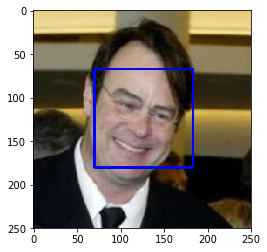

In [10]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [11]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    '''
    Predict if a image has a personn face
    
    Args:
        folder: path to a folder
        
    Returns:
        boolean  
    '''
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
The total percentaje of detected faces in 100 human files is 98% and 17% in 100 dog files. Maybe the detector is right and there is a person with a dog in some images.

In [12]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

# List all the predictions of face_detector over 100 images in human dataset al calculate the percentaje
face_in_humans = [face_detector(face) for face in human_files_short]
percentaje_in_humans = np.sum(face_in_humans) / len(human_files_short)

# List all the predictions of face_detector over 100 images in dog dataset al calculate the percentaje
face_in_dogs = [face_detector(face) for face in dog_files_short]
percentaje_in_dogs = np.sum(face_in_dogs) / len(dog_files_short)

# Print the percentajes obtained
print("Percentaje of detected faces in first 100 human files: "+"{:.2%}".format(percentaje_in_humans))
print("Percentaje of detected faces in first 100 dogs files: "+"{:.2%}".format(percentaje_in_dogs))

Percentaje of detected faces in first 100 human files: 98.00%
Percentaje of detected faces in first 100 dogs files: 17.00%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [13]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 97588357.15it/s] 


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

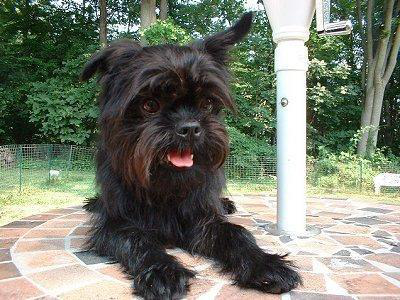

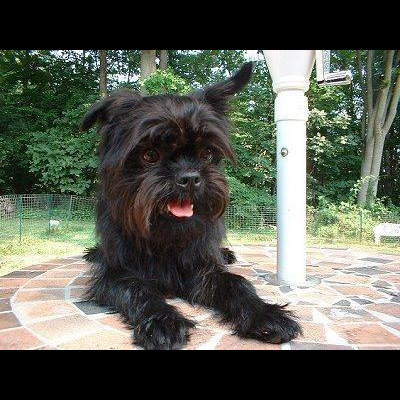

(400, 400)


In [14]:
# Show an image of a dog for reference
dog_sample =  dog_train_path + '/001.Affenpinscher/Affenpinscher_00001.jpg'
im = Image.open(dog_sample)
display(im)
# imshow(np.asarray(im))

def SquarePad(image):
    '''
    Reshape the image to square preserving the original aspect ratio
    Reference: https://discuss.pytorch.org/t/how-to-resize-and-pad-in-a-torchvision-transforms-compose/71850/4
    
    Args:
        image: A pillow image object
        
    Returns:
        An pillow image object
    '''

    # Extract the image width and height
    w, h = image.size
    # Find the longest axis
    max_wh = np.max([w, h])
    # Calculate the difference between an axis and the longest one
    # and divide it in order to use this value to pad the image
    hp = int((max_wh - w) / 2)
    vp = int((max_wh - h) / 2)
    # Make a tuple with the pad values: left, top, right and bottom
    padding = (hp, vp, hp, vp)
    # Apply the transformation to the original image, using a black to fill the image
    return transforms.functional.pad(image, padding, 0, 'constant')

# Pad the same dog image and show it next the original one
padded = SquarePad(im)
display(padded)
print(padded.size)

In [15]:

class SquarePad:
    '''
    Pads an image in order to obtain an square image without altering the original image 
    
    Reference: https://discuss.pytorch.org/t/how-to-resize-and-pad-in-a-torchvision-transforms-compose/71850/4
    '''
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return transforms.functional.pad(image, padding, 0, 'constant')

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    img = Image.open(img_path)
    
    preproccess = transforms.Compose([
            SquarePad(),
            transforms.Resize(size= (224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    img_preprocessed = preproccess(img).unsqueeze(0)
    
    # Use cuda if available
    if use_cuda:
        img_preprocessed = img_preprocessed.cuda()
    
    # Predict if there is a dog in the image 
    predict = VGG16(img_preprocessed)
    max_elements, max_indices = torch.max(predict, dim=1)

    
    ## Return the *index* of the predicted class for that image
    return max_indices.item() # predicted class index

In [16]:
# Test the function with a dog image
test_VGG16 = VGG16_predict(dog_sample)

print(test_VGG16)

252


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [17]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    '''
    Predict an image at specified path with VGG16_predict() function and
    check if its returned index is between 151 and 268 inclusive
    
    Args:
        img_path: path to an image
        
    Returns:
        Boolean depending of the require condition
    '''
    predicted_index = VGG16_predict(img_path)
    return predicted_index >= 151 and predicted_index <= 268

In [18]:
# Test the function with the same image as before
print(dog_detector(dog_sample))

True


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

0.0% of the images in 100 human files are detected as a dog and 99.0% of 100 images in dogdataset are detected as a dog

In [19]:
dogs_in_human_files = sum([dog_detector(file) for file in human_files_short]) / len(human_files_short) * 100
dogs_in_dogs_files = sum([dog_detector(file) for file in dog_files_short]) / len(dog_files_short) * 100

print(f'{dogs_in_human_files}% of the images in human_files_short are detected a dog')
print(f'{dogs_in_dogs_files}% of the images in dog_files_short are detected a dog')

0.0% of the images in human_files_short are detected a dog
99.0% of the images in dog_files_short are detected a dog


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [20]:
## Repeat the experiment with the inception model

# define inception model
inception = models.inception_v3(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    inception = inception.cuda()
    
inception = inception.eval()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.torch/models/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:03<00:00, 34979573.28it/s]


In [21]:
def inception_predict(img_path):
    '''
    Use pre-trained inception model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to inception model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    img = Image.open(img_path)
    
    preprocess = transforms.Compose([
            SquarePad(),
            transforms.Resize(299),
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    
    
    
    img_preprocessed = preprocess(img).unsqueeze(0)
    
    # Use cuda if available
    if use_cuda:
        img_preprocessed = img_preprocessed.cuda()
        
    # Predict if there is a dog in the image      
    predict = inception(img_preprocessed)
    max_elements, max_indices = torch.max(predict, dim=1)
    
    ## Return the *index* of the predicted class for that image
    return max_indices.item() # predicted class index

In [22]:
### returns "True" if a dog is detected in the image stored at img_path
def inception_dog_detector(img_path):
    '''
    Predict an image at specified path with inception_predict() function and
    check if its returned index is between 151 and 268 inclusive
    
    Args:
        img_path: path to an image
        
    Returns:
        Boolean depending of the require condition
    '''
    predicted_index = inception_predict(img_path)
    return predicted_index >= 151 and predicted_index <= 268

In [23]:
# Repeat the previous question with the inception model

dogs_in_human_files = sum([inception_dog_detector(file) for file in human_files_short]) / len(human_files_short) * 100
dogs_in_dogs_files = sum([inception_dog_detector(file) for file in dog_files_short]) / len(dog_files_short) * 100

print(f'{dogs_in_human_files}% of the images in human_files_short are detected a dog ')
print(f'{dogs_in_dogs_files}% of the images in dog_files_short are detected a dog')

1.0% of the images in human_files_short are detected a dog 
100.0% of the images in dog_files_short are detected a dog


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [24]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [25]:
# Define the transformations that will be applied in the data load process.
# We will apply random transformations just to the dataset
transform_train = transforms.Compose([
            SquarePad(),
            transforms.Resize(size= (224,224)),
            #transforms.ColorJitter(contrast=(0.3, 0.9), saturation=(0.3,0.9)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.CenterCrop(224),
            
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

transform_valid_test = transforms.Compose([
            SquarePad(),
            transforms.Resize(size= (224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

train_data = datasets.ImageFolder(dog_train_path, transform= transform_train)
valid_data = datasets.ImageFolder(dog_valid_path, transform= transform_valid_test)
test_data = datasets.ImageFolder(dog_test_path, transform= transform_valid_test)

# Specify batch size and number of workers
batch_size=80
num_workers=0

train_data_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=40,
                                          shuffle=True,
                                          num_workers=0)

valid_data_loader = torch.utils.data.DataLoader(valid_data,
                                          batch_size=40,
                                          shuffle=True,
                                          num_workers=0)

test_data_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=40,
                                          shuffle=False,
                                          num_workers=0)


loaders_scratch = {'train': train_data_loader, 'valid': valid_data_loader, 'test': test_data_loader}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
In the train dataset we will:
    - Pad the image to square with and height
    - Resize it to 224x 224. This is the size that the model is expecting
    - Random horizontal flips and rotation
    - Crop to 224x 224
    - Transform to tensor
    - Normalize with the values specified in the pytorch documentation 
    
whith this random transformations we are trying to prevent overfitting. Data augmentation will be done only in the train data loader. The valid and test data loader will make use of the same transformations except for the random flips and rotation. 

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [26]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (224x224x3)
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        # convolutional layer (112x112x64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        # convolutional layer (56x56x128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        # convolutional layer (28x28x256)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        # convolutional layer (14x14x512)
        self.conv5 = nn.Conv2d(512, 512, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (512 * 7 * 7 - 512)
        self.fc1 = nn.Linear(512 * 7 * 7, 512)
        # linear layer (512-133 classes)
        self.fc2 = nn.Linear(512, 133)
        # dropout layer
        self.dropout = nn.Dropout(0.5)
            
    def forward(self, x):
        # add sequence of forward procedure
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 7 * 7 * 512)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

In [27]:
print(Net())

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=133, bias=True)
  (dropout): Dropout(p=0.5)
)


__Answer:__ 
The 5 CNN layers will extract the features of the image while the pooling layers will reduce the dimensions. The dropout layer of 0.5 will prevent overfitting.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [28]:
criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.02, momentum=0.6)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [29]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            out = model(data)
            loss = criterion(out, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print(f'Validation loss has decreased. valid_loss_min {valid_loss_min},  valid_loss {valid_loss}')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss   
            
    # return trained model
    return model


# train the model
model_scratch = train(25, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.885350 	Validation Loss: 4.871611
Validation loss has decreased. valid_loss_min inf,  valid_loss 4.87161111831665
Epoch: 2 	Training Loss: 4.863935 	Validation Loss: 4.827975
Validation loss has decreased. valid_loss_min 4.87161111831665,  valid_loss 4.827975273132324
Epoch: 3 	Training Loss: 4.772276 	Validation Loss: 4.696670
Validation loss has decreased. valid_loss_min 4.827975273132324,  valid_loss 4.696670055389404
Epoch: 4 	Training Loss: 4.670452 	Validation Loss: 4.621601
Validation loss has decreased. valid_loss_min 4.696670055389404,  valid_loss 4.62160062789917
Epoch: 5 	Training Loss: 4.590785 	Validation Loss: 4.566857
Validation loss has decreased. valid_loss_min 4.62160062789917,  valid_loss 4.566856861114502
Epoch: 6 	Training Loss: 4.526876 	Validation Loss: 4.526931
Validation loss has decreased. valid_loss_min 4.566856861114502,  valid_loss 4.526931285858154
Epoch: 7 	Training Loss: 4.434966 	Validation Loss: 4.427763
Validation loss has d

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [30]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.637429


Test Accuracy: 16% (140/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [42]:
loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [48]:
import torchvision.models as models
import torch.nn as nn

vgg16_transfer = models.vgg16(pretrained=True)
    
print(vgg16_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [49]:
# Freeze training for all features layers
for param in vgg16_transfer.features.parameters():
    param.requires_grad = False

# Find the input of the last layer    
n_inputs= vgg16_transfer.classifier[6].in_features

# Define a new layer with the last value and the total classes of dog breed
last_layer = nn.Linear(n_inputs, train_breeds)

# Add the new layer to the net
vgg16_transfer.classifier[6] = last_layer

# Use cuda if available
if use_cuda:
    vgg16_transfer = vgg16_transfer.cuda()

# Check the new out of the net
print(vgg16_transfer.classifier[6].out_features)

133


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [50]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(vgg16_transfer.classifier.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [51]:
# train the model
n_epochs = 10
vgg16_transfer = train(n_epochs, loaders_transfer, vgg16_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
vgg16_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 4.510095 	Validation Loss: 3.686669
Validation loss has decreased. valid_loss_min 3.686669111251831,  valid_loss 3.686669111251831
Epoch: 2 	Training Loss: 3.190184 	Validation Loss: 2.250568
Validation loss has decreased. valid_loss_min 2.250568389892578,  valid_loss 2.250568389892578
Epoch: 3 	Training Loss: 2.053194 	Validation Loss: 1.358606
Validation loss has decreased. valid_loss_min 1.3586061000823975,  valid_loss 1.3586061000823975
Epoch: 4 	Training Loss: 1.468097 	Validation Loss: 0.996394
Validation loss has decreased. valid_loss_min 0.9963937401771545,  valid_loss 0.9963937401771545
Epoch: 5 	Training Loss: 1.160687 	Validation Loss: 0.816013
Validation loss has decreased. valid_loss_min 0.8160128593444824,  valid_loss 0.8160128593444824
Epoch: 6 	Training Loss: 1.010477 	Validation Loss: 0.720270
Validation loss has decreased. valid_loss_min 0.7202697396278381,  valid_loss 0.7202697396278381
Epoch: 7 	Training Loss: 0.917266 	Validation Loss: 0.66

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [53]:
test(loaders_transfer, vgg16_transfer, criterion_transfer, use_cuda)

Test Loss: 0.616144


Test Accuracy: 82% (687/836)


In [64]:
print(loaders_transfer['train'].dataset.classes)


['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita', '005.Alaskan_malamute', '006.American_eskimo_dog', '007.American_foxhound', '008.American_staffordshire_terrier', '009.American_water_spaniel', '010.Anatolian_shepherd_dog', '011.Australian_cattle_dog', '012.Australian_shepherd', '013.Australian_terrier', '014.Basenji', '015.Basset_hound', '016.Beagle', '017.Bearded_collie', '018.Beauceron', '019.Bedlington_terrier', '020.Belgian_malinois', '021.Belgian_sheepdog', '022.Belgian_tervuren', '023.Bernese_mountain_dog', '024.Bichon_frise', '025.Black_and_tan_coonhound', '026.Black_russian_terrier', '027.Bloodhound', '028.Bluetick_coonhound', '029.Border_collie', '030.Border_terrier', '031.Borzoi', '032.Boston_terrier', '033.Bouvier_des_flandres', '034.Boxer', '035.Boykin_spaniel', '036.Briard', '037.Brittany', '038.Brussels_griffon', '039.Bull_terrier', '040.Bulldog', '041.Bullmastiff', '042.Cairn_terrier', '043.Canaan_dog', '044.Cane_corso', '045.Cardigan_welsh_

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [82]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path):
    '''
    Use the transfer learning model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to inception model's prediction
    '''
    
    # Load and pre-process an image from the given img_path
    img = Image.open(img_path)
    
    preprocess = transforms.Compose([
            SquarePad(),
            transforms.Resize(244),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    
    img_preprocessed = preprocess(img).unsqueeze(0)
    
    # Use cuda if availalbe
    if use_cuda:
        img_preprocessed = img_preprocessed.cuda()
     
    # Predict the image
    predict = vgg16_transfer(img_preprocessed)
    max_elements, max_indices = torch.max(predict, dim=1)
    
    
    ## Return the *index* of the predicted class for that image
    return class_names[max_indices.item()] # predicted class index

In [83]:
predict_breed_transfer(dog_sample)

'Affenpinscher'

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [96]:
def run_app(img_path, show=False):
    '''
    Predict the breed of a dog in the image. If there is a human, predict the resembling dog breed
    
    Args:
        img_path: path to an image
        
    Returns:
        Print the result
    '''
    
    # Show the image if it´s asked
    if show:
        img = Image.open(img_path)
        display(img)
    
    # Check if there is a person or a dog in the image with the detectors
    is_person = face_detector(img_path)
    is_dog = dog_detector(img_path)
    
    # Respond with an error if there is not
    if not is_person and not is_dog:
        return 'ERROR! - Cannot find neither a dog nor a human'
    
    # Predict the breed with the last model
    subject = 'dog' if is_dog else 'human'
    dog_breed = predict_breed_transfer(img_path)
    
    # Print the result
    print(f'There is a {subject} in the picture that looks like a {dog_breed}' )   

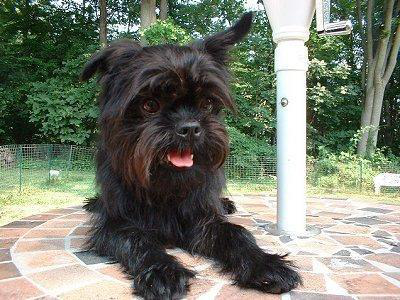

There is a dog in the picture that looks like a Affenpinscher


In [97]:
# Test the function
run_app(dog_sample, True)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__
The algorithm has positively surprised me. The logic of the function was surpringly simple and effective.
The algorithm assumes that there will only be one person or one dog in the image, but if the image has two dogs or a person and a dog, we are predicting it wrong. This will be the main improvement to do. 
The second one will be change the models under the dog and person detection. Maybe the best solution would be improve the last model with a balanced dataset and use it in the dog detector, too. Haar cascades it´s fast and effective, but there are other options that could lead to a better result, such as mxnet. 
Another option is to use the same model for dog and human detection, yolo for example. Maybe this can be done with a simple yolo.
The last improvement I propose is to use a base64 image as an input. This way we can take this code with the models and make an api with it that can answer to a mobile app.

In [99]:
def show_image(img):
    img = Image.open(img_path)
    display(img)

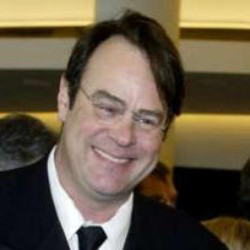

There is a human in the picture that looks like a Dachshund


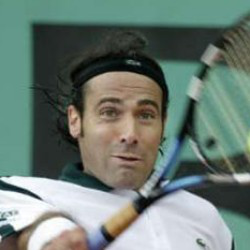

There is a human in the picture that looks like a Ibizan hound


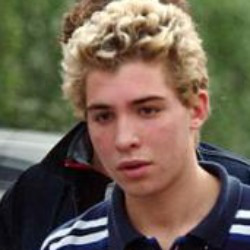

There is a human in the picture that looks like a Portuguese water dog


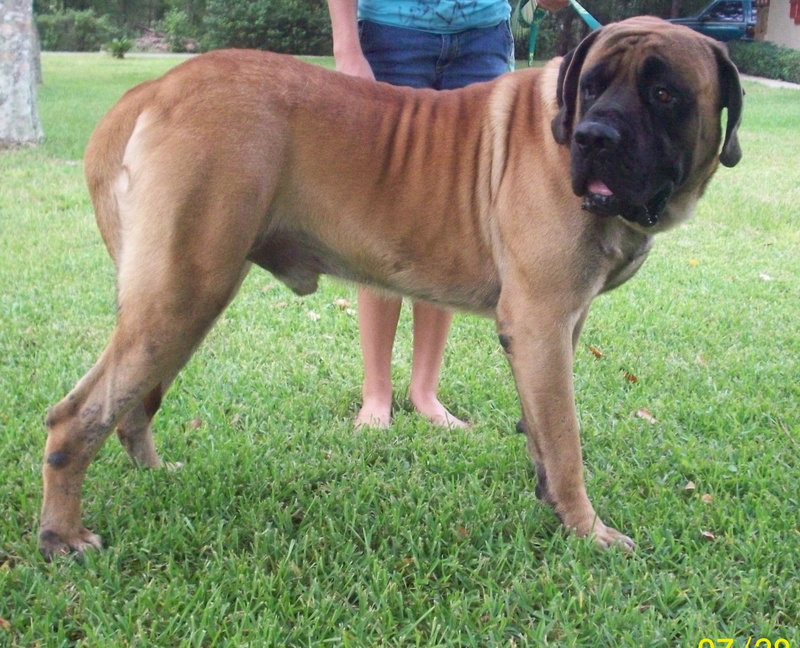

There is a dog in the picture that looks like a Bullmastiff


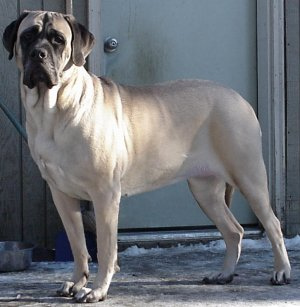

There is a dog in the picture that looks like a Mastiff


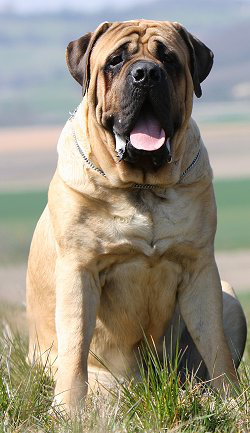

There is a dog in the picture that looks like a Bullmastiff


In [100]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file, True)